In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

In [2]:
class ExampleAgent(Agent):

    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        return self.env.action_space.sample()   

In [3]:
def plot_pic(log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    from matplotlib.ticker import MultipleLocator
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

### Q1

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


' Resetting the environment '

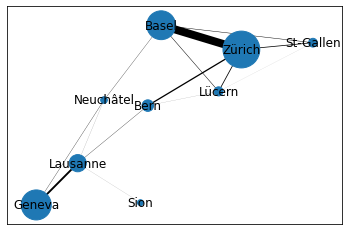

In [4]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

""" Resetting the environment """
 # We pass a seed to the env to ensure reproductibility 

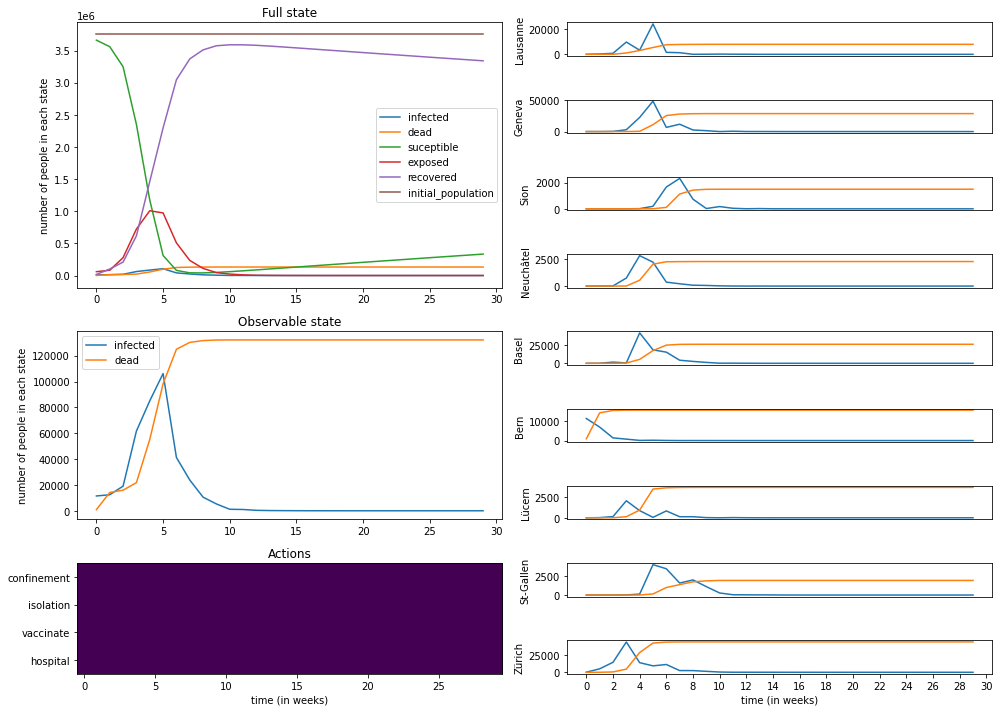

In [5]:
action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
"""One step amounts to one week in the simulation environment"""
obs, reward, done, info = env.step(action)

agent = ExampleAgent(env)
log = []
finished = False
obs, info = env.reset(42)
agent.reset()
agent.epsilon = 0
while not finished:
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

plot_pic(log)

### Q2

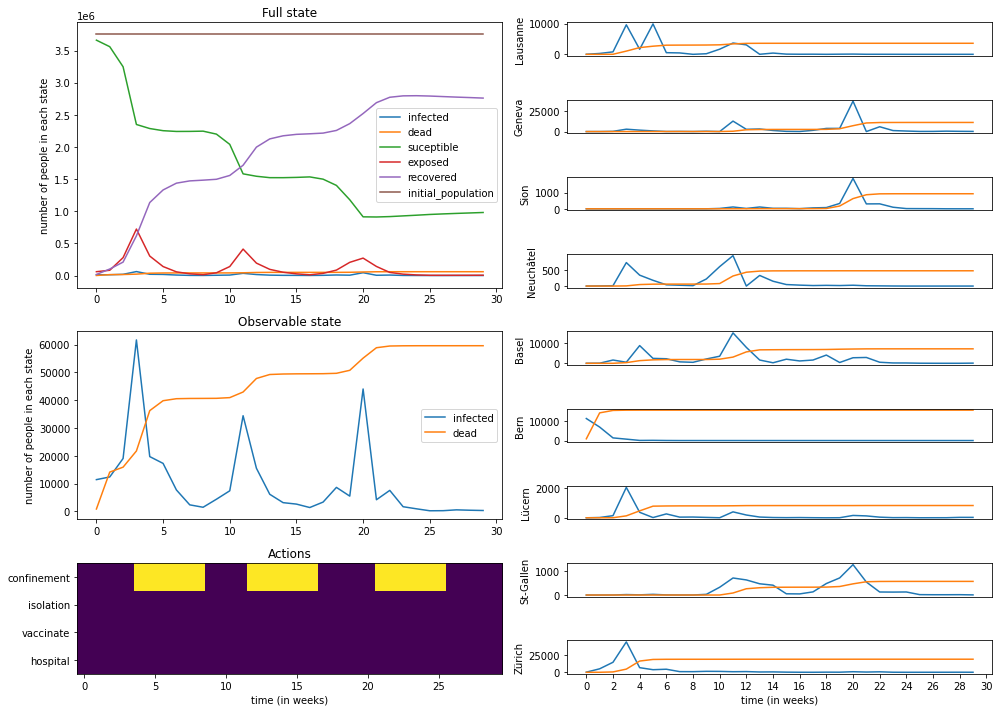

In [8]:
def russuo_action(confine):
    if confine == 1: 
        return {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
    else:
        return {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}

class RussuoAgent(Agent):
    def __init__(self,  env:Env, 
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.duration = 0
        self.count = 0

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        if self.duration > 0: 
            self.duration = self.duration - 1 
            self.count = self.count + 1 
            return russuo_action(1)
        if obs.total.infected[-1] > 20000:
            self.duration = 4
            self.count = self.count + 1
            return russuo_action(1)
        else:
            return russuo_action(0)

"""One step amounts to one week in the simulation environment"""
obs, reward, done, info = env.step(action)

agent2 = RussuoAgent(env)
log2 = []
finished = False
obs, info = env.reset(42)
agent2.reset()
agent2.epsilon = 0
while not finished:
    action = agent2.act(obs)
    obs, R, finished, info = env.step(action)
    log2.append(info) # save the information dict for logging
    if finished:
        break

plot_pic(log2)

In [30]:
""" Plot example """

def russuo_evaluate():
    deaths_list, rewards_list, conf_days = [],[],[]
    seeds = range(20)
    for i in range(20):
        total_deaths = 0
        total_rewards = 0
        total_conf = 0
        
        finished = False
        obs, info = env.reset(seeds[i])

        agent2 = RussuoAgent(env)
        agent2.reset()
        agent2.epsilon = 0
        while not finished:
            action = agent2.act(obs)
            obs, R, finished, info = env.step(action)
            
            total_rewards += float(R)
            log2.append(info) # save the information dict for logging
            if finished:
                deaths_list.append(obs.total.dead)
                break
        
        rewards_list.append(total_rewards)
        conf_days.append(agent2.count * 7)
    return deaths_list, rewards_list, conf_days


deaths, rewards, conf_days = russuo_evaluate()


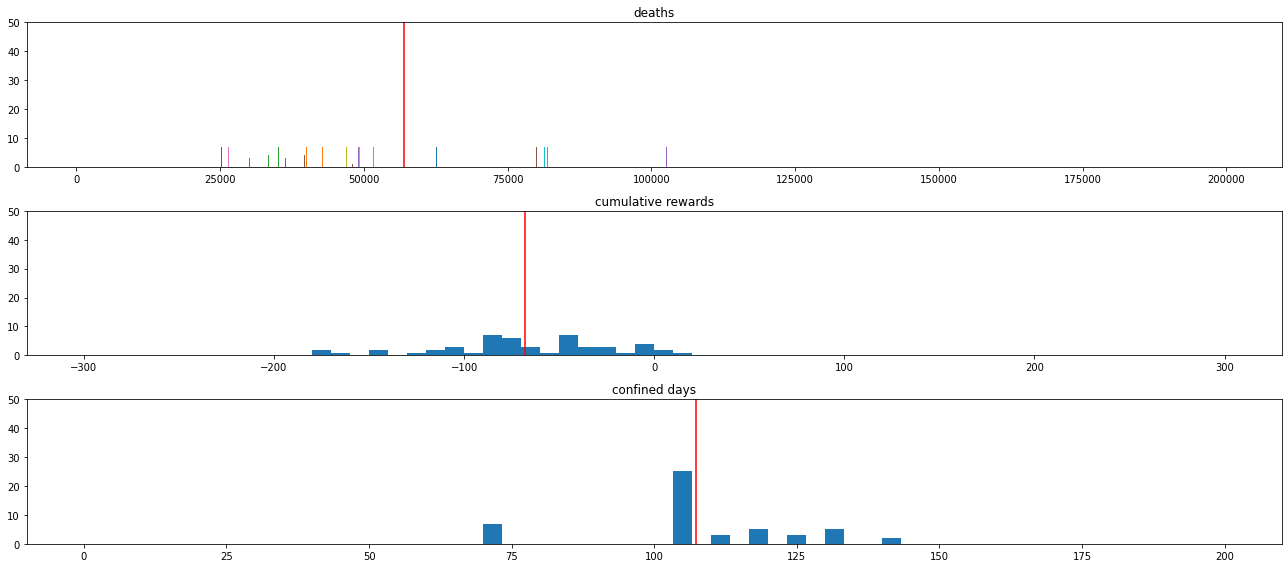

Average death number: 56946.24571428572
Average number of confined days: 107.38
Average cumulative reward: -68.05005590382963


In [31]:
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')